In [168]:
# Import necessary libraries
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import regex

In [169]:
# load data
data = pd.read_parquet('../data/curated/features_domain.parquet')  

In [170]:
data.drop(columns=['url','price','latitude','longitude','geometry', 'geometry_proj', 'index_right','bond'], inplace=True)

In [171]:
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

/var/folders/b6/nv55vzd50gz6bs69664021z00000gn/T/ipykernel_96392/352924614.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


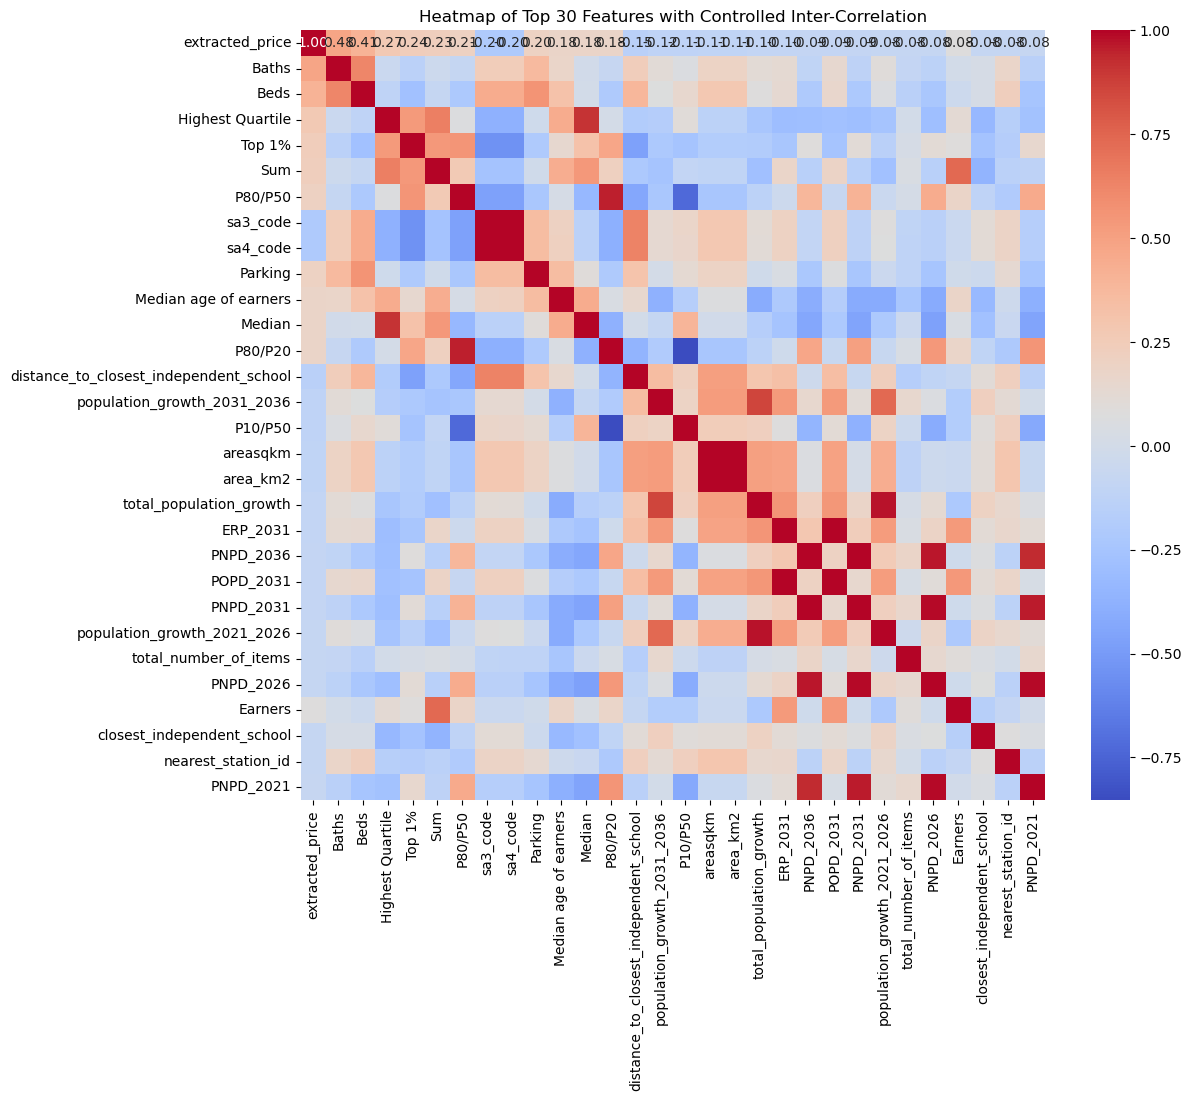

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'domain_dataset' is your DataFrame
corr_matrix = data.corr()

# Extract the correlations with the target variable
target_corr = corr_matrix['extracted_price'].abs().sort_values(ascending=False)

# Select the top 50 features for initial analysis, including your target
top_features = target_corr.head(50).index

# Create a smaller correlation matrix for these top features
top_corr_matrix = corr_matrix.loc[top_features, top_features]

# Target number of features to retain
target_feature_count = 30

# List to keep track of features to drop
to_drop = []

while len(top_features) - len(to_drop) > target_feature_count:
    # Compute the current reduced correlation matrix
    current_corr_matrix = top_corr_matrix.drop(index=to_drop, columns=to_drop)
    # Calculate the mean absolute correlation of each feature with others
    mean_abs_corr = current_corr_matrix.apply(lambda x: x.abs().drop(x.name).mean(), axis=0)
    # Find the feature with the highest mean correlation
    max_corr_feature = mean_abs_corr.idxmax()
    to_drop.append(max_corr_feature)

# Remaining features after dropping
remaining_features = [feature for feature in top_features if feature not in to_drop]

# Final DataFrame with reduced feature set
final_corr_matrix = corr_matrix.loc[remaining_features, remaining_features]

# Visualizing the final set of features with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Top 30 Features with Controlled Inter-Correlation')
plt.show()


In [174]:
# Assuming 'domain_dataset' is your DataFrame and 'remaining_features' contains the list of feature names to retain
reduced_dataset = data[remaining_features]

# Optionally, include the target variable if it's not already in 'remaining_features'
if 'extracted_price' not in remaining_features:
    reduced_dataset['extracted_price'] = data['extracted_price']

# Now 'reduced_dataset' contains only the features of interest
print(reduced_dataset.head())  # Displaying the first few rows of the new DataFrame to verify


   extracted_price  Baths  Beds  Highest Quartile  Top 1%        Sum  P80/P50  \
0           1400.0    3.0   4.0              30.4    13.1  872950324     2.24   
1            750.0    2.0   4.0              30.4    13.1  872950324     2.24   
2           1300.0    2.0   5.0              30.4    13.1  872950324     2.24   
3            825.0    1.0   3.0              30.4    13.1  872950324     2.24   
4            680.0    2.0   3.0              30.4    13.1  872950324     2.24   

   sa3_code  sa4_code  Parking  ...   PNPD_2036     POPD_2031   PNPD_2031  \
0     21102       211      2.0  ...  361.211596  16775.060722  329.732136   
1     21102       211      0.0  ...  361.211596  16775.060722  329.732136   
2     21102       211      2.0  ...  361.211596  16775.060722  329.732136   
3     21102       211      5.0  ...  361.211596  16775.060722  329.732136   
4     21102       211      2.0  ...  361.211596  16775.060722  329.732136   

   population_growth_2021_2026  total_number_of_it

In [175]:
# Assuming 'domain_dataset' is your DataFrame and already loaded
numeric_df = reduced_dataset.select_dtypes(include=[np.number])
# Separating the independent variables and the dependent variable
X = numeric_df.drop('extracted_price', axis=1)
y = numeric_df['extracted_price']

# Convert categorical columns to category dtype or one-hot encode them if necessary
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding categorical features

# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the XGBoost Regressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

# Step 6: Get Feature Importance
importance = model.feature_importances_


RMSE: 129.65


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [177]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort the DataFrame by Importance and select the top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
feature_importance_df.to_csv('../data/curated/feature_importance_xgboost.csv')
# Print the top 10 most important features
print("Top 20 Most Important Features:")
print(top_features)


Top 20 Most Important Features:
                        Feature  Importance
6                      sa3_code    0.395109
0                         Baths    0.124977
1                          Beds    0.063303
15                     areasqkm    0.043736
5                       P80/P50    0.033189
3                        Top 1%    0.031497
17      total_population_growth    0.029968
9         Median age of earners    0.028456
2              Highest Quartile    0.026734
10                       Median    0.019281
11                      P80/P20    0.016594
24                    PNPD_2026    0.015460
13  population_growth_2031_2036    0.013526
27           nearest_station_id    0.013338
8                       Parking    0.012994
18                     ERP_2031    0.012871
4                           Sum    0.012863
28                    PNPD_2021    0.012385
22  population_growth_2021_2026    0.012281
20                    POPD_2031    0.011982
